# Описание проекта

Банку необходимо по данным клиентов предсказать, кто из них в ближайшее время захочет расторгнуть договор.

Для этого нужно построить модель классификации со  значением *F1*-меры не менее 0.59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)


# Используемые библиотеки

Pandas, numpy, matplotlib, sklearn

## План исследования

1. Подготовка данных
2. Исследование задачи
3. Борьба с дисбалансом
4. Тестирование моделей
5. Проверка моделей на адекватность
6. Общий вывод

# 1. Подготовка данных <a id='section1'></a>

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score

Загрузим и проверим данные

In [2]:
df = pd.read_csv('Churn.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Необходимо выполнить следующие действия:
* Перевести все числовые значения в int32
* Убрать столбец с фамилиями
* Перевести категориальные признаки в численные
* Заполнить пропуски в Tenure

Изменим типы данных

In [3]:
columns_to_int32 = ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 
                    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

# Временно заполним пропуски в Tenure минус единицами
df['Tenure'] = df['Tenure'].fillna(-1)

for column in columns_to_int32:
    df[column] =  df[column].astype('int32')

Уберем столбец с фамилиями

In [4]:
df = df.drop(['Surname'] , axis=1)

Переведем категориальные признаки в численные

In [5]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'],drop_first=True)
df.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2,0,1,1,1,101348,1,0,0,0
1,2,15647311,608,41,1,83807,1,0,1,112542,0,0,1,0
2,3,15619304,502,42,8,159660,3,1,0,113931,1,0,0,0
3,4,15701354,699,39,1,0,2,0,0,93826,0,0,0,0
4,5,15737888,850,43,2,125510,1,1,1,79084,0,0,1,0


#### Заполним пропуски в Tenure

In [6]:
# Отделим заполненные значения
df_pos = df.query('Tenure >= 0')

Для заполнения напишем функцию, которая для каждого пропуска будет искать людей с такими же полом, возрастом, страной. После этого функция будет находить медиану количества недвижимости в найденых строках и вставлять ее вместо пропуска.

In [7]:
%%time

def fill_pass(pas):
    for i in range(len(df)):
        if df.loc[i, pas] < 0: # Выбирает пропущенные значения

            df.loc[i, pas] = (           # Присваиваем пропуску значение
                df_pos[
                    (df_pos['Age'] == df.loc[i, 'Age']) & 
                    (df_pos['Geography_Germany'] == df.loc[i, 'Geography_Germany']) & 
                    (df_pos['Geography_Spain'] == df.loc[i, 'Geography_Spain']) & 
                    (df_pos['Gender_Male'] == df.loc[i, 'Gender_Male'])
                ]
                [pas].median()   # Берем медиану искмой характеристики из найденных строк
            )

# Запускаем функцию 
fill_pass('Tenure')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int32  
 1   CustomerId         10000 non-null  int32  
 2   CreditScore        10000 non-null  int32  
 3   Age                10000 non-null  int32  
 4   Tenure             9997 non-null   float64
 5   Balance            10000 non-null  int32  
 6   NumOfProducts      10000 non-null  int32  
 7   HasCrCard          10000 non-null  int32  
 8   IsActiveMember     10000 non-null  int32  
 9   EstimatedSalary    10000 non-null  int32  
 10  Exited             10000 non-null  int32  
 11  Geography_Germany  10000 non-null  uint8  
 12  Geography_Spain    10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(1), int32(10), uint8(3)
memory usage: 498.2 KB
Wall time: 1.53 s


Осталось всего 3 пропуска. Удалим строки с пропусками. 

In [8]:
df = df.dropna()

# Округлим данные и поменяем тип
df['Tenure'] = df['Tenure'].round().astype('int32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   RowNumber          9997 non-null   int32
 1   CustomerId         9997 non-null   int32
 2   CreditScore        9997 non-null   int32
 3   Age                9997 non-null   int32
 4   Tenure             9997 non-null   int32
 5   Balance            9997 non-null   int32
 6   NumOfProducts      9997 non-null   int32
 7   HasCrCard          9997 non-null   int32
 8   IsActiveMember     9997 non-null   int32
 9   EstimatedSalary    9997 non-null   int32
 10  Exited             9997 non-null   int32
 11  Geography_Germany  9997 non-null   uint8
 12  Geography_Spain    9997 non-null   uint8
 13  Gender_Male        9997 non-null   uint8
dtypes: int32(11), uint8(3)
memory usage: 536.9 KB


#### Вывод:
Пропуски заполнены, данные приведены к нужным типам, категориальные признаки переведены в численные.

# 2. Борьба с дисбалансом

Проверим баланс классов

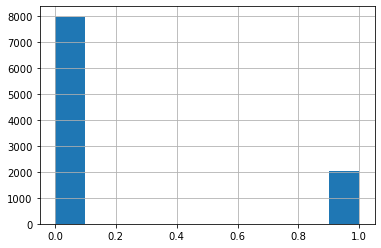

In [9]:
df['Exited'].hist()

Обнаружен явный дисбаланс. Значения отличаются примерно в 4 раза.

#### Разделим данные на тренировочные и тестовые в соотношении 7:3.

In [10]:
features = df.drop(['Exited', 'RowNumber', 'CustomerId'], axis=1)
target = df['Exited']


features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345)


print(features_train.shape)
print(features_test.shape)

(6997, 11)
(3000, 11)


Проверим полученные колонки с признаками

In [11]:
features_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

#### Подготовим данные с применением техники downsample

Напишем и применим функцию, которая уменьшит количество значений 0 целевого признака в 4 раза

In [12]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#### Подготовим данные с применением техники upsample

Напишем и применим функцию, которая увеличит количество значений 1 целевого признака в 4 раза

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Вывод:
Мы получили 3 набора обучающих данных:  
1) Стандартный с дисбалансом  
2) С применением техники Downsample  
3) С применением техники Upsample  

Теперь необходимо протестировать все выбранные модели, обученные на различных наборах данных.

# 3. Подготовка моделей <a id='section2'></a>

Создадим таблицу для результатов тестов моделей на разных обучающих данных

In [14]:
result = pd.DataFrame([['LogisticRegression', '', '', ''], ['RandomForestClassifier', '', '', ''], 
                       ['LGBMClassifier', '', '', '']],
                     columns=['Model', 'Default data', 'Upsampled', 'Downsampled'])

### Логистическая регрессия

Подготовим сетку с гиперпараметрами для логистической регрессии

In [15]:
parameters_grid = {
    'C' : list(np.logspace(-5, 5, num=11, endpoint=True, base=10.0)),
    'class_weight' : ['balanced', None],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear']
}

Напишем функцию, которая обучит выбранныую модель (логистическая регрессия, случайный лес, градиентный бустинг) на указанных обучающих данных (исходные, downsampling, upsampling), подберет оптимальные гиперпараметры случайным перебором по сетке и выведет метрику F1 на тестовых данных

In [16]:
def test_model(model, features, target, iterations):
    
    if model == 'lr':
        rscv = RandomizedSearchCV(LogisticRegression(), parameters_grid, scoring='f1_micro', n_iter=iterations)
        rscv.fit(features, target)
        m = LogisticRegression(**rscv.best_params_)
    if model == 'rfc':
        rscv = RandomizedSearchCV(RandomForestClassifier(), parameters_grid, scoring='f1_micro', n_iter=iterations)
        rscv.fit(features, target)
        m = RandomForestClassifier(**rscv.best_params_)
    if model == 'lgb':
        rscv = RandomizedSearchCV(lgb.LGBMClassifier(), parameters_grid, scoring='f1_micro', n_iter=iterations)
        rscv.fit(features, target)
        m = lgb.LGBMClassifier(**rscv.best_params_)
    
    m.fit(features, target)
    
    predictions = m.predict(features_test)
    f1 = f1_score(target_test, predictions)
    print('F1 = ', f1)
    print('Best params:', rscv.best_params_)

Применим функцию (логистическая регрессия, исходные данные)

In [17]:
%%time
model = LogisticRegression()
test_model('lr', features_train, target_train, 100)

F1 =  0.28571428571428575
Best params: {'solver': 'newton-cg', 'class_weight': None, 'C': 1000.0}
Wall time: 43.1 s


Запишем результат в таблицу

In [18]:
result['Default data'][0] = 0.286

Применим функцию (логистическая регрессия, downsampling)

In [19]:
%%time
test_model('lr', features_downsampled, target_downsampled, 100)

F1 =  0.5085748078060319
Best params: {'solver': 'newton-cg', 'class_weight': 'balanced', 'C': 0.01}
Wall time: 29 s


In [20]:
result['Downsampled'][0] = 0.509

Применим функцию (логистическая регрессия, upsampling)

In [21]:
%%time
test_model('lr', features_upsampled, target_upsampled, 100)

F1 =  0.5020527859237537
Best params: {'solver': 'newton-cg', 'class_weight': None, 'C': 0.001}
Wall time: 1min 10s


In [22]:
result['Upsampled'][0] = 0.502

### Случайный лес

Подготовим сетку с гиперпараметрами для случайного леса

In [23]:
parameters_grid = {
    'n_estimators' : range(80,120,10),
    'min_samples_split' : range(2,4,1),
    'min_samples_leaf' : range(2,4,1),
    'max_depth' : range(8,28,2)
}

Применим функцию (случайный лес, исходные данные)

In [24]:
%%time
test_model('rfc', features_train, target_train, 100)

F1 =  0.56875
Best params: {'n_estimators': 80, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 12}
Wall time: 4min 9s


In [25]:
result['Default data'][1] = 0.569

Применим функцию (случайный лес, downsampling)

In [26]:
%%time
test_model('rfc', features_downsampled, target_downsampled, 100)

F1 =  0.5947712418300652
Best params: {'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 8}
Wall time: 2min 9s


In [28]:
result['Downsampled'][1] = 0.595

Применим функцию (случайный лес, upsampling)

In [29]:
%%time
test_model('rfc', features_upsampled, target_upsampled, 100)

F1 =  0.6165540540540541
Best params: {'n_estimators': 90, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 24}
Wall time: 6min 16s


In [30]:
result['Upsampled'][1] = 0.617

### Градиентный бустинг

Подготовим сетку с гиперпараметрами для градиентного бустинга

In [31]:
parameters_grid = {
    'max_depth' : range(2, 20, 2),
    'num_leaves' : range(80,120,10),
    'learning_rate' : np.arange(0.4, 0.8, 0.02),
    'n_estimators' : range(80, 120, 10),
}

In [32]:
%%time
test_model('lgb', features_train, target_train, 100)

F1 =  0.5911330049261083
Best params: {'num_leaves': 80, 'n_estimators': 110, 'max_depth': 2, 'learning_rate': 0.42000000000000004}
Wall time: 1min 31s


In [33]:
result['Default data'][2] = 0.591

In [34]:
%%time
test_model('lgb', features_downsampled, target_downsampled, 100)

F1 =  0.5785226567349473
Best params: {'num_leaves': 100, 'n_estimators': 110, 'max_depth': 2, 'learning_rate': 0.6000000000000002}
Wall time: 1min 5s


In [35]:
result['Downsampled'][2] = 0.579

In [36]:
%%time
test_model('lgb', features_upsampled, target_upsampled, 100)

F1 =  0.5803489439853077
Best params: {'num_leaves': 110, 'n_estimators': 90, 'max_depth': 16, 'learning_rate': 0.5600000000000002}
Wall time: 1min 40s


In [37]:
result['Upsampled'][2] = 0.580

In [38]:
result

,Model,Default data,Upsampled,Downsampled
0,LogisticRegression,0.286,0.502,0.509
1,RandomForestClassifier,0.569,0.617,0.595
2,LGBMClassifier,0.591,0.58,0.579


### Вывод:
Из всех моделей требованиям по метрике F1 (> 5.9) удовлетворяют только RandomForestClassifier (upsampling и downsampling) и LGBMClassifier, обученный на изначальных данных. 

Далее модели RandomForestClassifier (upsampling) и LGBMClassifier (изначальные данные) проверим на адекватность. 

# 4. Проверка моделей на адекватность

Чтобы проверить наши модели на адекватность, нужно сравнить их AUC_ROC, с AUC_ROC при подстановке наиболее популярного значения (в нашем случае 0).

In [39]:
# создадим последовательность из нулей по длине равную target_test
zeros = target_test * 0

Подготовим предсказания вероятностей ухода клиента выбранных моделей

In [40]:
rfc = RandomForestClassifier(n_estimators=90, min_samples_split=3, min_samples_leaf=2, max_depth=24)
rfc.fit(features_upsampled, target_upsampled)
proba_rfc = rfc.predict_proba(features_test)
probabilities_one_rfc = proba_rfc[:, 1]

lgbmc = lgb.LGBMClassifier(num_leaves=80, n_estimators=110, max_depth=2, learning_rate=0.42000000000000004)
lgbmc.fit(features_train, target_train)
proba_lgbmc = lgbmc.predict_proba(features_test)
probabilities_one_lgbmc = proba_lgbmc[:, 1]

Рассчитаем AUC_ROC моделей и AUC_ROC при подстановке нулей

In [41]:
auc_roc = roc_auc_score(target_test, probabilities_one_rfc)
print("AUC_ROC модели RFC (Upsampling) = {:.3f}".format(auc_roc))


auc_roc = roc_auc_score(target_test, probabilities_one_lgbmc)
print("AUC_ROC модели LGBMC (default data) = {:.3f}".format(auc_roc))


auc_roc = roc_auc_score(target_test, zeros)
print("AUC_ROC при нулях = {:.3f}".format(auc_roc))

AUC_ROC модели RFC (Upsampling) = 0.848
AUC_ROC модели LGBMC (default data) = 0.862
AUC_ROC при нулях = 0.500


#### Вывод:
Проверка на адекватность показала, что предсказания выбранных моделей значительно точнее подстановки популярного значения. 

AUC_ROC RFC (Upsampling) = 0.848

AUC_ROC LGBMC (default data) = 0.862

AUC_ROC при нулях = 0.500

# 5. Исследуем важность факторов

Для каждой модели создадим табличку с факторами (признаками) и их важностью при предсказании целевого признака.

Также напишем функцию, которая объеденит такие признаки как Geography_Spain и Geography_France просто в Geography. Далее важности таких факторов будут просуммированны.

Полученные данные представим в виде круговой диаграммы. 

Text(0.5, 1.0, 'Важность факторов для RFR')

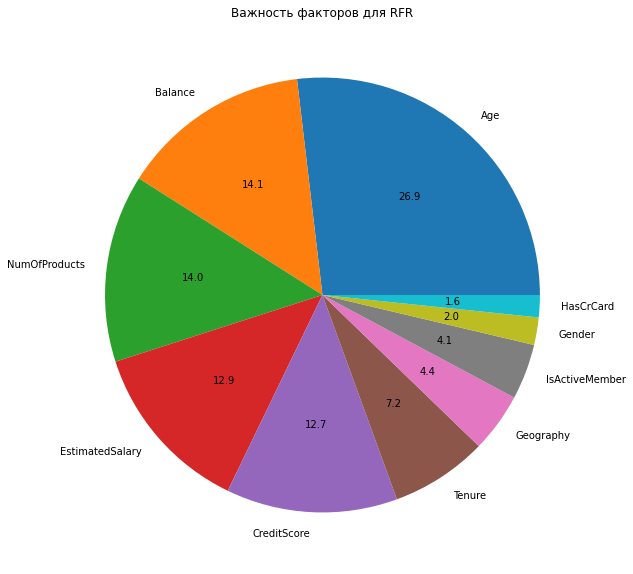

In [42]:
importances = pd.DataFrame(columns=['Factor', 'Importance'])
importances['Factor'] = features.columns
importances['Importance'] = rfc.feature_importances_


def feature_group(feature): # Функция будет оставлять только наименование признака, без его значения (Geography) 
    if '_' in feature:      # Например Geography_Spain превратит просто в Geography
        group = feature[ : feature.find("_")]
        return group
    else:
        return feature

importances.Factor = importances.Factor.apply(feature_group) # применим функцию к столбцу Factor

importances = importances.groupby(by=['Factor']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()


plt.figure(figsize=(10,10))
plt.pie(importances['Importance'], labels=importances['Factor'], autopct='%.1f')
plt.title('Важность факторов для RFR')

Сделаем тоже самое для LGBMC

Text(0.5, 1.0, 'Важность факторов для LGBMC')

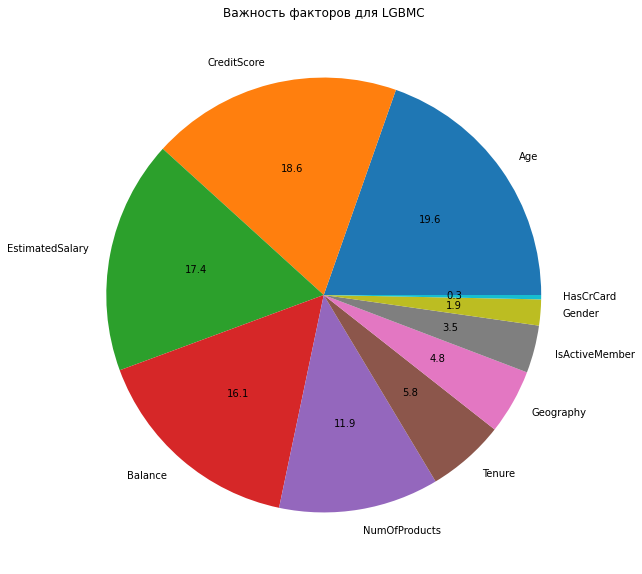

In [43]:
importances = pd.DataFrame(columns=['Factor', 'Importance'])
importances['Factor'] = features.columns
importances['Importance'] = lgbmc.feature_importances_

importances.Factor = importances.Factor.apply(feature_group) # применим функцию к столбцу Factor

importances = importances.groupby(by=['Factor']).sum().sort_values(by='Importance', ascending=False)
importances = importances.reset_index()


plt.figure(figsize=(10,10))
plt.pie(importances['Importance'], labels=importances['Factor'], autopct='%.1f')
plt.title('Важность факторов для LGBMC')

### Вывод:
Для обеих моделей самыми важными факторами оказались: возраст, баланс, количество продуктов, примерный доход и кредитный рейтинг. Остальные факторы манее значимы, но в сумме могут иметь важность до 19.3 %. 

# 6. Общий вывод <a id='section6'></a>

При изучении данных было обнаружено, что есть пропуски в столбце Tenure (количество недвижимости). Пропуски были заполнены медианами среди похожих клиентов (пол, возраст, страна). Также категориальные признаки были переведены в численные.

Полученные данные были разделены на тренировочную и тестовую выборки в соотношении 7/3 соответственно. 

В целевом признаке был обнаружен дисбаланс. Применены техники upsampling и downsampling. Решено протестировать все модели с различной обработкой дисбаланса.

Были протестированны следующие модели с подбором оптимальных параметров:
* Логистическая регрессия
* Случайный лес
* Градиентный бустинг (LGBMC)

In [44]:
result

,Model,Default data,Upsampled,Downsampled
0,LogisticRegression,0.286,0.502,0.509
1,RandomForestClassifier,0.569,0.617,0.595
2,LGBMClassifier,0.591,0.58,0.579


Наиболее точный показала модель случайного леса с применением техники upsample. 

Значение F1 на тестовой выборке получилось 0.617.

Модели RFC (Upsampling) и LGBMC (исходные данные) были проверенны на адекватность, путем сравнения AUC_ROC моделей с AUC_ROC при подстановке нулей. Предсказания моделей получились значительно точнее подстановки популярного значения. 

AUC_ROC RFC (Upsampling) = 0.848  
AUC_ROC LGBMC (default data) = 0.862  
AUC_ROC при нулях = 0.500

Также была проверена важность признаков. Для обеих моделей самыми важными факторами оказались: возраст, баланс, количество продуктов, примерный доход и кредитный рейтинг.